In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/finaldata/iod_conv.csv')
# 1. Initial Data Inspection
print("Initial Data Inspection:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Initial Data Inspection:
Shape: (1672, 4)

First 5 rows:
   Day     Month  Year     Value
0   18   October  1992 -1.366068
1   26   October  1992 -1.495621
2    2  November  1992 -1.077333
3    9  November  1992 -1.099429
4   15  November  1992 -1.073329

Data Types:
 Day        int64
Month     object
Year       int64
Value    float64
dtype: object

Missing Values:
 Day      0
Month    0
Year     0
Value    0
dtype: int64


In [3]:
# 2. Date Conversion and Index Handling
# Convert to integers and handle potential float representations
df['Year'] = df['Year'].astype(int)
df['Day'] = df['Day'].astype(int)

# Create datetime column
df['Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' + df['Month'] + '-' + df['Day'].astype(str),
    format='%Y-%B-%d',
    errors='coerce'
)

# Handle missing dates and set index
df = df.dropna(subset=['Date'])
df = df.set_index('Date').asfreq('D').interpolate(method='time')

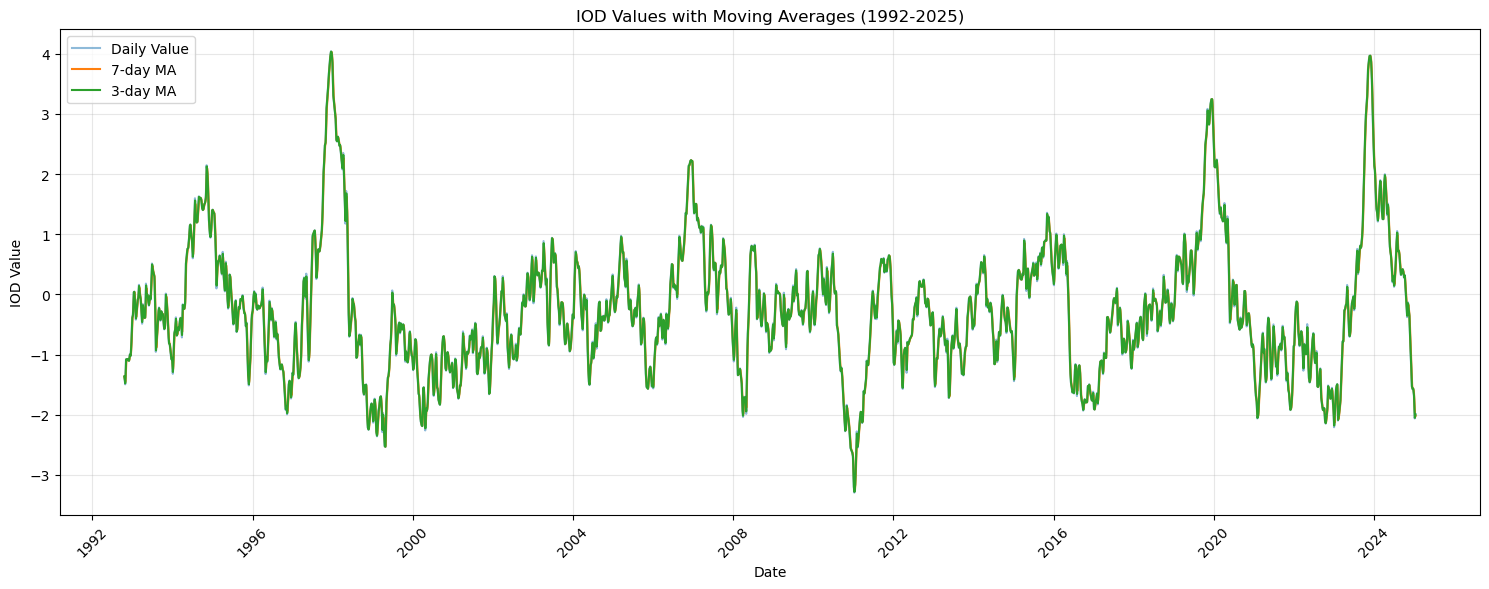

In [4]:
# 3. Temporal Analysis with Moving Averages
plt.figure(figsize=(15, 6))
df['7_day_MA'] = df['Value'].rolling(window=7, min_periods=1).mean()
df['3_day_MA'] = df['Value'].rolling(window=3, min_periods=1).mean()

sns.lineplot(data=df, x=df.index, y='Value', label='Daily Value', alpha=0.5)
sns.lineplot(data=df, x=df.index, y='7_day_MA', label='7-day MA')
sns.lineplot(data=df, x=df.index, y='3_day_MA', label='3-day MA')
plt.title('IOD Values with Moving Averages (1992-2025)')
plt.xlabel('Date')
plt.ylabel('IOD Value')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

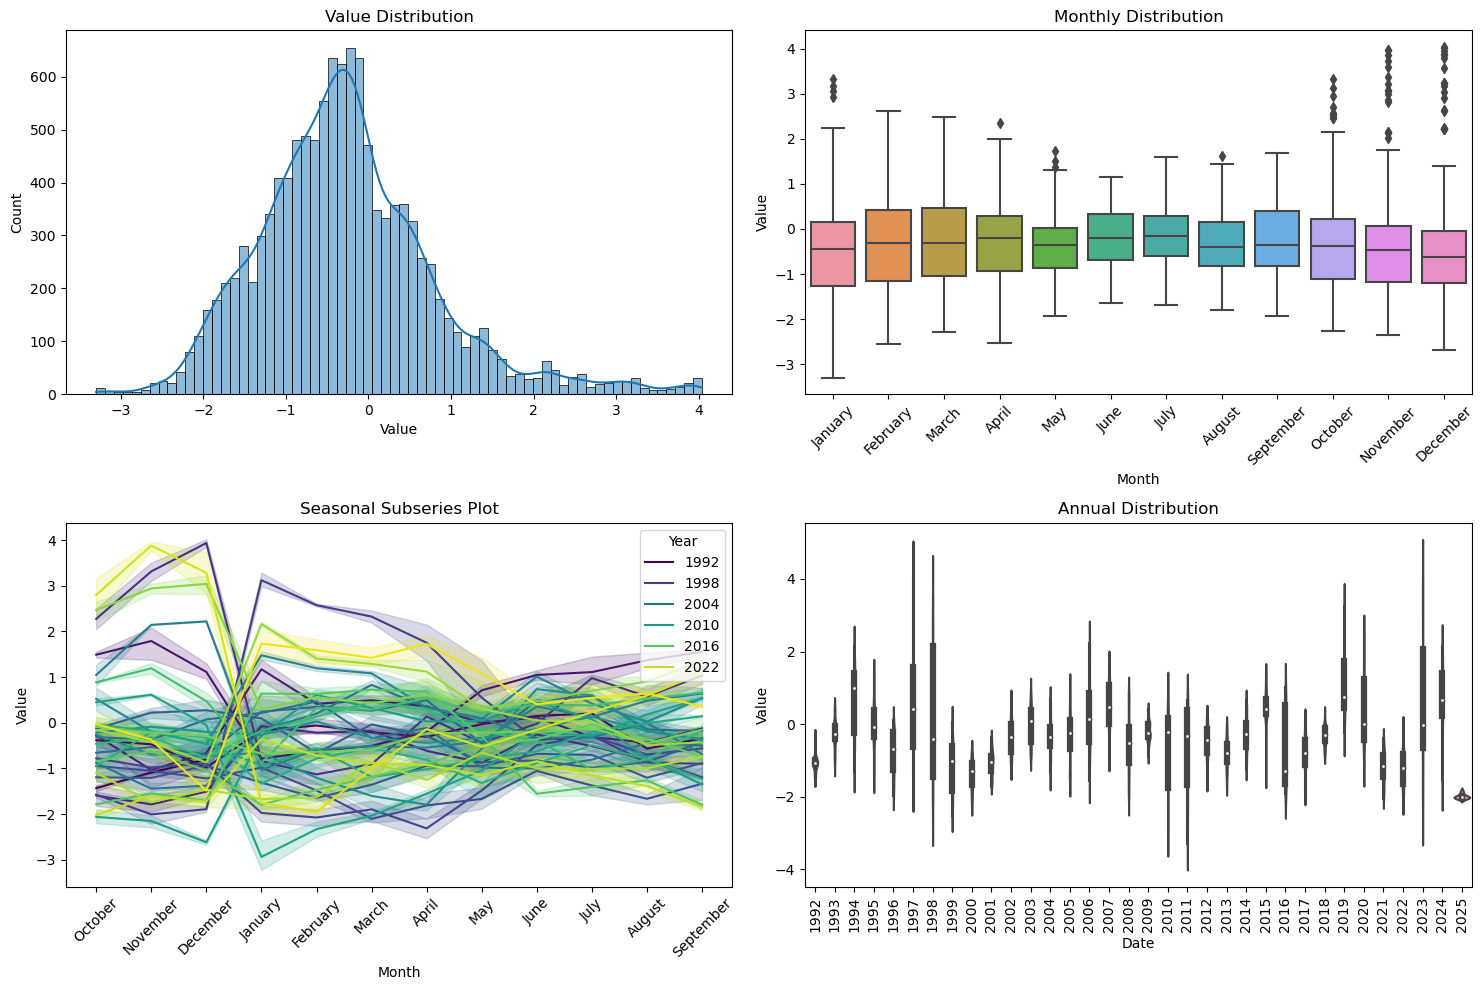

In [5]:
# 4. Distribution Analysis
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
sns.histplot(df['Value'], kde=True, ax=ax[0,0])
ax[0,0].set_title('Value Distribution')

# Boxplot by Month
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
sns.boxplot(x=df['Month'], y=df['Value'], order=month_order, ax=ax[0,1])
ax[0,1].set_title('Monthly Distribution')
ax[0,1].tick_params(axis='x', rotation=45)

# Seasonal Subseries Plot
seasonal_df = df.copy()
seasonal_df['Year'] = seasonal_df.index.year
sns.lineplot(x='Month', y='Value', hue='Year', data=seasonal_df, 
            estimator='mean', ax=ax[1,0], palette='viridis')
ax[1,0].set_title('Seasonal Subseries Plot')
ax[1,0].tick_params(axis='x', rotation=45)

# Annual Distribution
sns.violinplot(x=df.index.year, y=df['Value'], ax=ax[1,1])
ax[1,1].set_title('Annual Distribution')
ax[1,1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


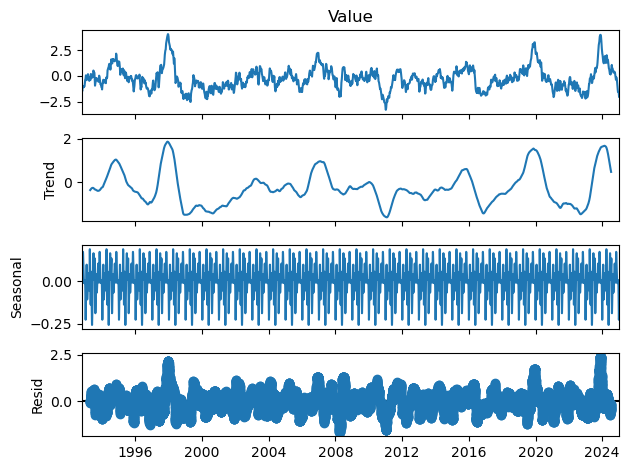

In [6]:
# 5. Advanced Time Series Analysis
# Decomposition with 365-day period
result = seasonal_decompose(df['Value'].interpolate(), model='additive', period=365)
result.plot()
plt.tight_layout()
plt.show()

In [7]:
# 6. Statistical Analysis
print("\nKey Statistics:")
print(f"Date Range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Value Range: {df['Value'].min():.2f} to {df['Value'].max():.2f}")
print("\nCorrelation with Moving Averages:")
print(df[['Value', '3_day_MA', '7_day_MA']].corr())


Key Statistics:
Date Range: 1992-10-18 to 2025-01-12
Value Range: -3.30 to 4.04

Correlation with Moving Averages:
             Value  3_day_MA  7_day_MA
Value     1.000000  0.999494  0.996069
3_day_MA  0.999494  1.000000  0.998227
7_day_MA  0.996069  0.998227  1.000000


In [8]:
# 7. Outlier Detection
Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1
print(f"\nIQR Range: {Q1 - 1.5*IQR:.2f} to {Q3 + 1.5*IQR:.2f}")
print("Potential Outliers:", df[(df['Value'] < (Q1 - 1.5*IQR)) | 
                               (df['Value'] > (Q3 + 1.5*IQR))].shape[0])


IQR Range: -2.80 to 2.14
Potential Outliers: 425


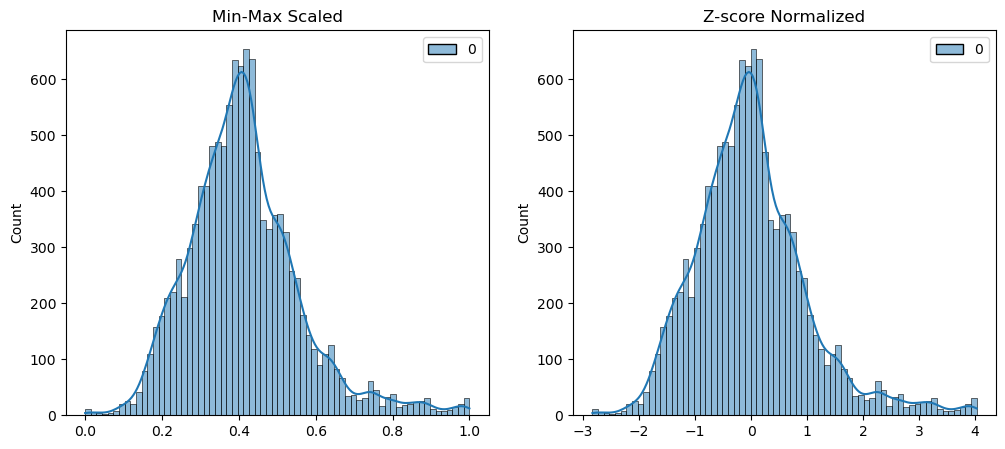

In [9]:
# 8. Normalization Comparison
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(scaler.fit_transform(df[['Value']]), kde=True)
plt.title('Min-Max Scaled')

plt.subplot(1,2,2)
sns.histplot(standard_scaler.fit_transform(df[['Value']]), kde=True)
plt.title('Z-score Normalized')
plt.show()